# Projeto Marinha do Brasil

## Laboratorio de Processamento de Sinais - UFRJ

#### Autor: Vinícius dos Santos Mello (viniciudsmello@poli.ufrj.br)

In [97]:
import os
import pickle
import numpy as np
import time
from keras import backend as K
import sklearn.metrics

from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'StackedAutoEncoder'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/picts'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = False
development_events = 400

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)

    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Time to import all libraries: 2.00271606445e-05 seconds
Time to read data file: 1.71875691414 seconds
Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)


In [13]:
%%time
# Train Function
from Functions import TrainParameters as trnparams
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
import keras.callbacks as callbacks

from keras.utils import np_utils

def StackedAutoEncoderTrainFunction(data=None, trgt=None, 
                                    ifold=0, n_folds=2, n_neurons=10, 
                                    trn_params=None, save_path='', dev=False):
    
    if n_neurons == 0:
        n_neurons = 1
    
    # load or create cross validation ids
    CVO = trnparams.ClassificationFolds(folder=save_path,n_folds=n_folds,trgt=trgt,dev=dev)

    n_folds = len(CVO)
    n_inits = trn_params.params['n_inits']

    params_str = trn_params.get_params_str()
    
    analysis_str = 'StackedAutoEncoder'
    prefix_str = 'RawData'

    model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                   prefix_str,n_folds,
                                                   params_str,n_neurons)

    
    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
        if os.path.exists(file_name):
            if trn_params.params['verbose']:
                print 'File %s exists'%(file_name)
            return 0
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        if os.path.exists(file_name):
            if trn_params.params['verbose']:
                print 'File %s exists'%(file_name)
            return 0

    #print "Fold: %i"%(ifold+1)
    train_id, test_id = CVO[ifold]

    #normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])

    norm_data = scaler.transform(data)
    norm_trgt = norm_data
    
    best_init = 0
    best_loss = 999

    classifier = []
    trn_desc = {}

    for i_init in range(n_inits):
        print 'Neuron: %i - Fold %i of %i Folds -  Init %i of %i Inits'%(n_neurons, 
                                                                         ifold+1, 
                                                                         n_folds, 
                                                                         i_init+1,
                                                                         n_inits)
        model = Sequential()
        model.add(Dense(n_neurons, input_dim=data.shape[1], init="uniform"))
        model.add(Activation(trn_params.params['hidden_activation']))
        model.add(Dense(data.shape[1], init="uniform")) 
        model.add(Activation(trn_params.params['output_activation']))
        
        adam = Adam(lr=trn_params.params['learning_rate'], 
                    beta_1=trn_params.params['beta_1'],
                    beta_2=trn_params.params['beta_2'],
                    epsilon=trn_params.params['epsilon'])
        
        model.compile(loss='mean_squared_error', 
                      optimizer=adam,
                      metrics=['accuracy'])
        # Train model
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=trn_params.params['patience'],
                                                verbose=trn_params.params['train_verbose'], 
                                                mode='auto')

        init_trn_desc = model.fit(norm_data[train_id], norm_trgt[train_id], 
                                  nb_epoch=trn_params.params['n_epochs'], 
                                  batch_size=trn_params.params['batch_size'],
                                  callbacks=[earlyStopping], 
                                  verbose=trn_params.params['verbose'],
                                  validation_data=(norm_data[test_id],
                                                   norm_trgt[test_id]),
                                  shuffle=True)
        if np.min(init_trn_desc.history['val_loss']) < best_loss:
            best_init = i_init
            best_loss = np.min(init_trn_desc.history['val_loss'])
            classifier = model
            trn_desc['epochs'] = init_trn_desc.epoch
            trn_desc['acc'] = init_trn_desc.history['acc']
            trn_desc['loss'] = init_trn_desc.history['loss']
            trn_desc['val_loss'] = init_trn_desc.history['val_loss']
            trn_desc['val_acc'] = init_trn_desc.history['val_acc']

    # save model
    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
        classifier.save(file_name)
        file_name = '%s_fold_%i_trn_desc.jbl'%(model_str,ifold)
        joblib.dump([trn_desc],file_name,compress=9)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        classifier.save(file_name)
        file_name = '%s_fold_%i_trn_desc_dev.jbl'%(model_str,ifold)
        joblib.dump([trn_desc],file_name,compress=9)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 26.9 µs


In [79]:
%%time
# load parameters

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
#os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

n_folds = 2
CVO = trnparams.ClassificationFolds(folder=results_path,
                                    n_folds=n_folds,
                                    trgt=all_trgt,
                                    dev=development_flag, verbose=False)
print trn_params.get_params_str()

1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_tanh_output_activation
CPU times: user 5.94 ms, sys: 0 ns, total: 5.94 ms
Wall time: 7.06 ms


## Treinamento sem processamento paralelo

In [ ]:
"""for ifold in range(len(CVO)):
    for ineuron in range(1,20,1):
        NeuralTrainFunction(data=all_data,
                            trgt=all_trgt,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=True)"""

## Treinamento com processamento paralelo

In [ ]:
%%time
# To train on multiple cores sweeping the number of folds
    def trainFold(ifold):
        ineuron = 20
        return StackedAutoEncoderTrainFunction(data=all_data,
                                trgt=all_data,
                                ifold=ifold,
                                n_folds=n_folds, 
                                n_neurons=ineuron,
                                trn_params=trn_params, 
                                save_path=results_path,
                                dev=development_flag)
# To train on multiple cores sweeping the number of neurons
def trainNeuron(ineuron):
    for ifold in range(len(CVO)):
        StackedAutoEncoderTrainFunction(data=all_data,
                            trgt=all_data,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)

In [ ]:
%time
from multiprocessing import Pool
num_processes = 10
p = Pool(processes=num_processes)
start_time = time.time()
folds = range(len(CVO))
neurons = range(0, 825, 75) # Train from 0 to 750
# To train on multiple cores sweeping the number of folds
#results = p.map(trainFold, folds)

# To train on multiple cores sweeping the number of neurons
results = p.map(trainNeuron, neurons)

p.close()
p.join()
end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

In [ ]:
print end_time/60

# Análises com variação de Neurônios

In [ ]:
# Neuron variation x MSE

from sklearn import preprocessing
from sklearn import metrics

from keras.utils import np_utils
from keras.models import load_model

from Functions import TrainParameters as trnparams

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'mse'

analysis_file_name='%s/%s/%s_%s_neuron_number_sweep.jbl'%(results_path,analysis_str,analysis_name, current_analysis)

#os.remove(analysis_file_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                             hidden_activation='tanh',
                                                             output_activation='tanh',
                                                             n_epochs=500,
                                                             patience=50,
                                                             batch_size=256,
                                                             verbose=False)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.NeuralClassificationTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = 2
    CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    neurons_mat = range(0,825,75) + [400, 425]
    neurons_mat.sort()
    
    mse_mat = np.zeros([n_folds,len(neurons_mat)])

    for ifold in range(len(CVO)):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

        norm_data = scaler.transform(all_data[test_id,:])

        for ineuron,neuron_value in enumerate(neurons_mat):     
            if neuron_value == 0:
                neuron_value = 1
            model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                       model_prefix_str,
                                                       n_folds,
                                                       params_str,
                                                       neuron_value)

            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
            print file_name
            if not os.path.exists(file_name):
                def trainFold(ifold):
                    ineuron = neuron_value
                    return StackedAutoEncoderTrainFunction(data=all_data,
                                            trgt=all_data,
                                            ifold=ifold,
                                            n_folds=n_folds, 
                                            n_neurons=ineuron,
                                            trn_params=trn_params, 
                                            save_path=results_path,
                                            dev=development_flag)
                from multiprocessing import Pool
                num_processes = 10
                p = Pool(processes=num_processes)
                folds = range(len(CVO))
                results = p.map(trainFold, folds)
                p.close()
                p.join()
                
                
            model = load_model(file_name)
            output = model.predict(norm_data)
            mse = metrics.mean_squared_error(norm_data, output)
            mse_mat[ifold,ineuron] = mse
            
    joblib.dump([mse_mat,neurons_mat],analysis_file_name,compress=9)
else:
    [mse_mat,neurons_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(neurons_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)

ax.set_title('MSE per Hidden Layer size',fontsize=18,weight='bold')
ax.set_xlabel('Neurons Quantity',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold') 
ax.grid()
print trn_params.get_params_str()

/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_tanh_output_activation_1_neurons_fold_0_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_tanh_output_activation_75_neurons_fold_0_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_tanh_output_activation_150_neurons_fold_0_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_tanh_output_activation_225_neurons_fold_0_model.h5
/home/vinicius.mello/Workspace/SonarAnalysis/Results/Classification/StackedAutoEncoder/RawData_2_folds_1_inits_

Topology (1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_tanh_output_activation)


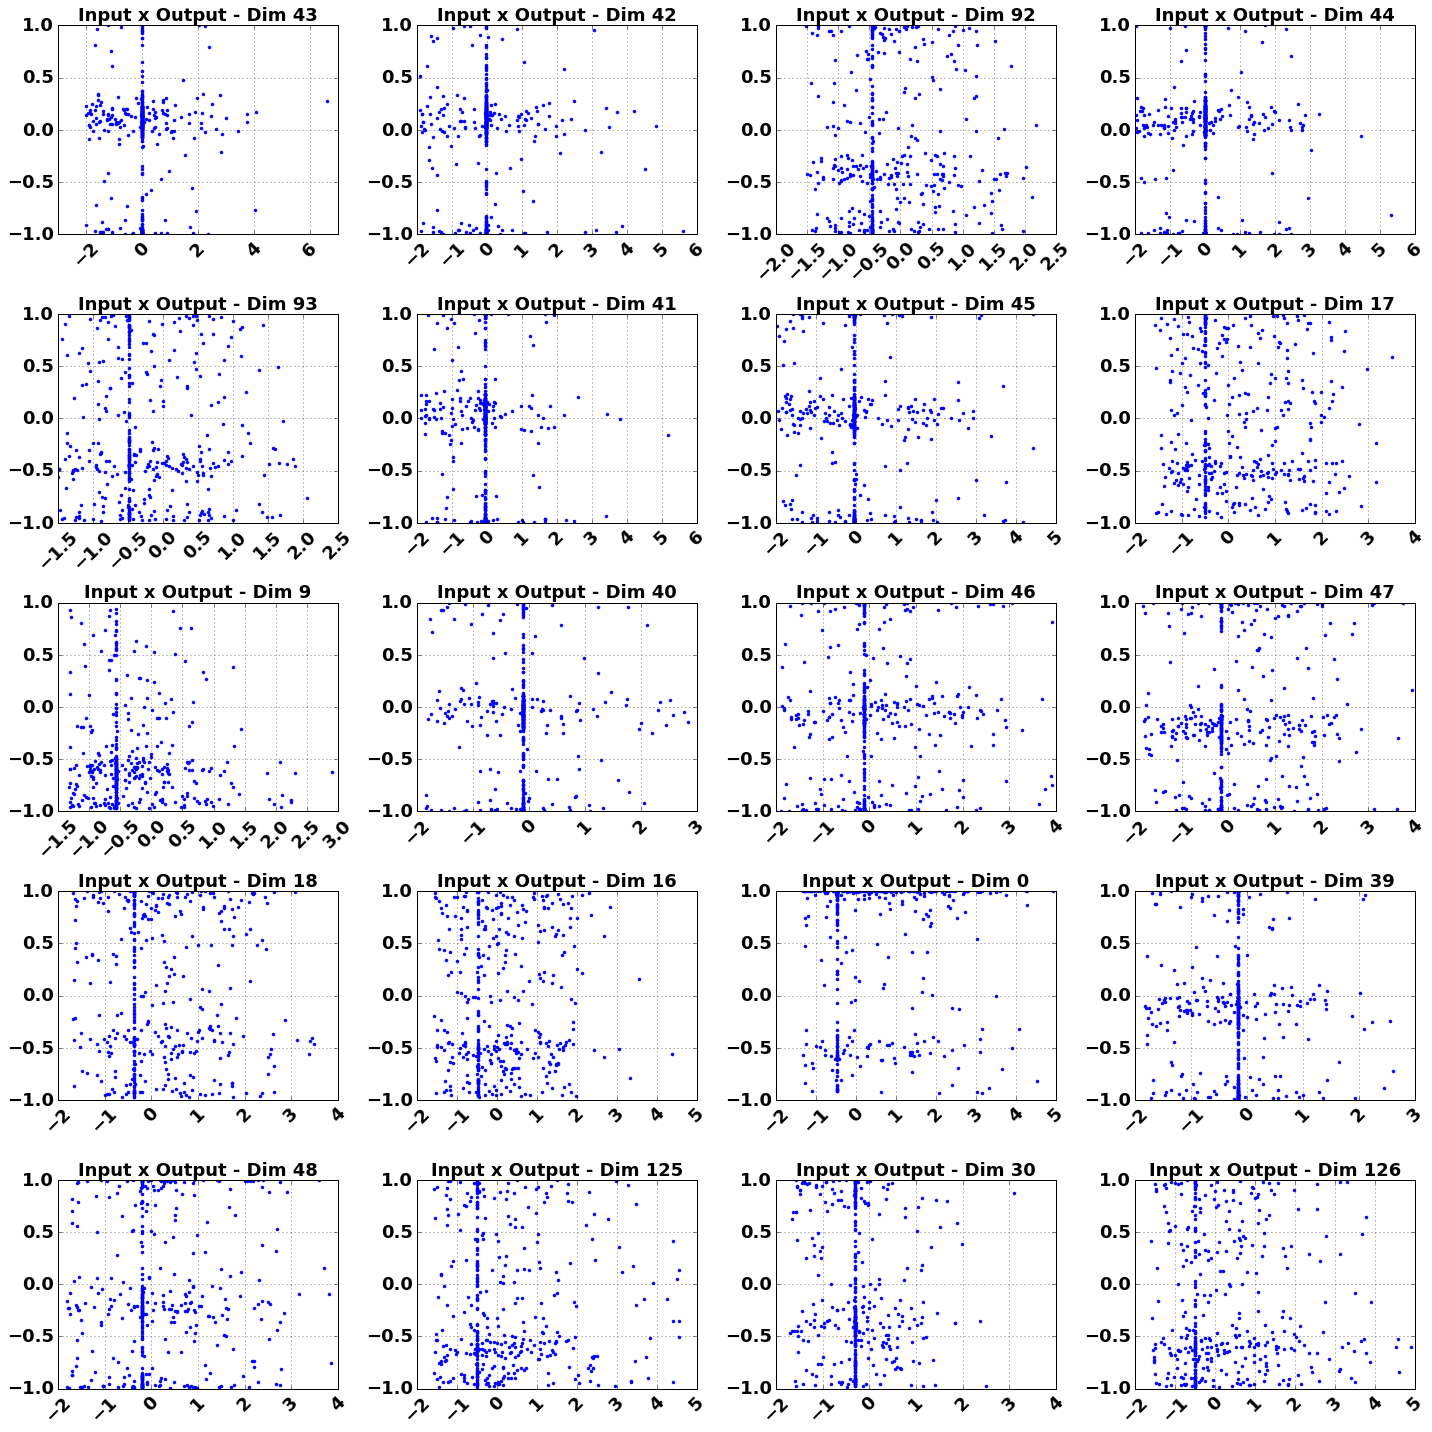

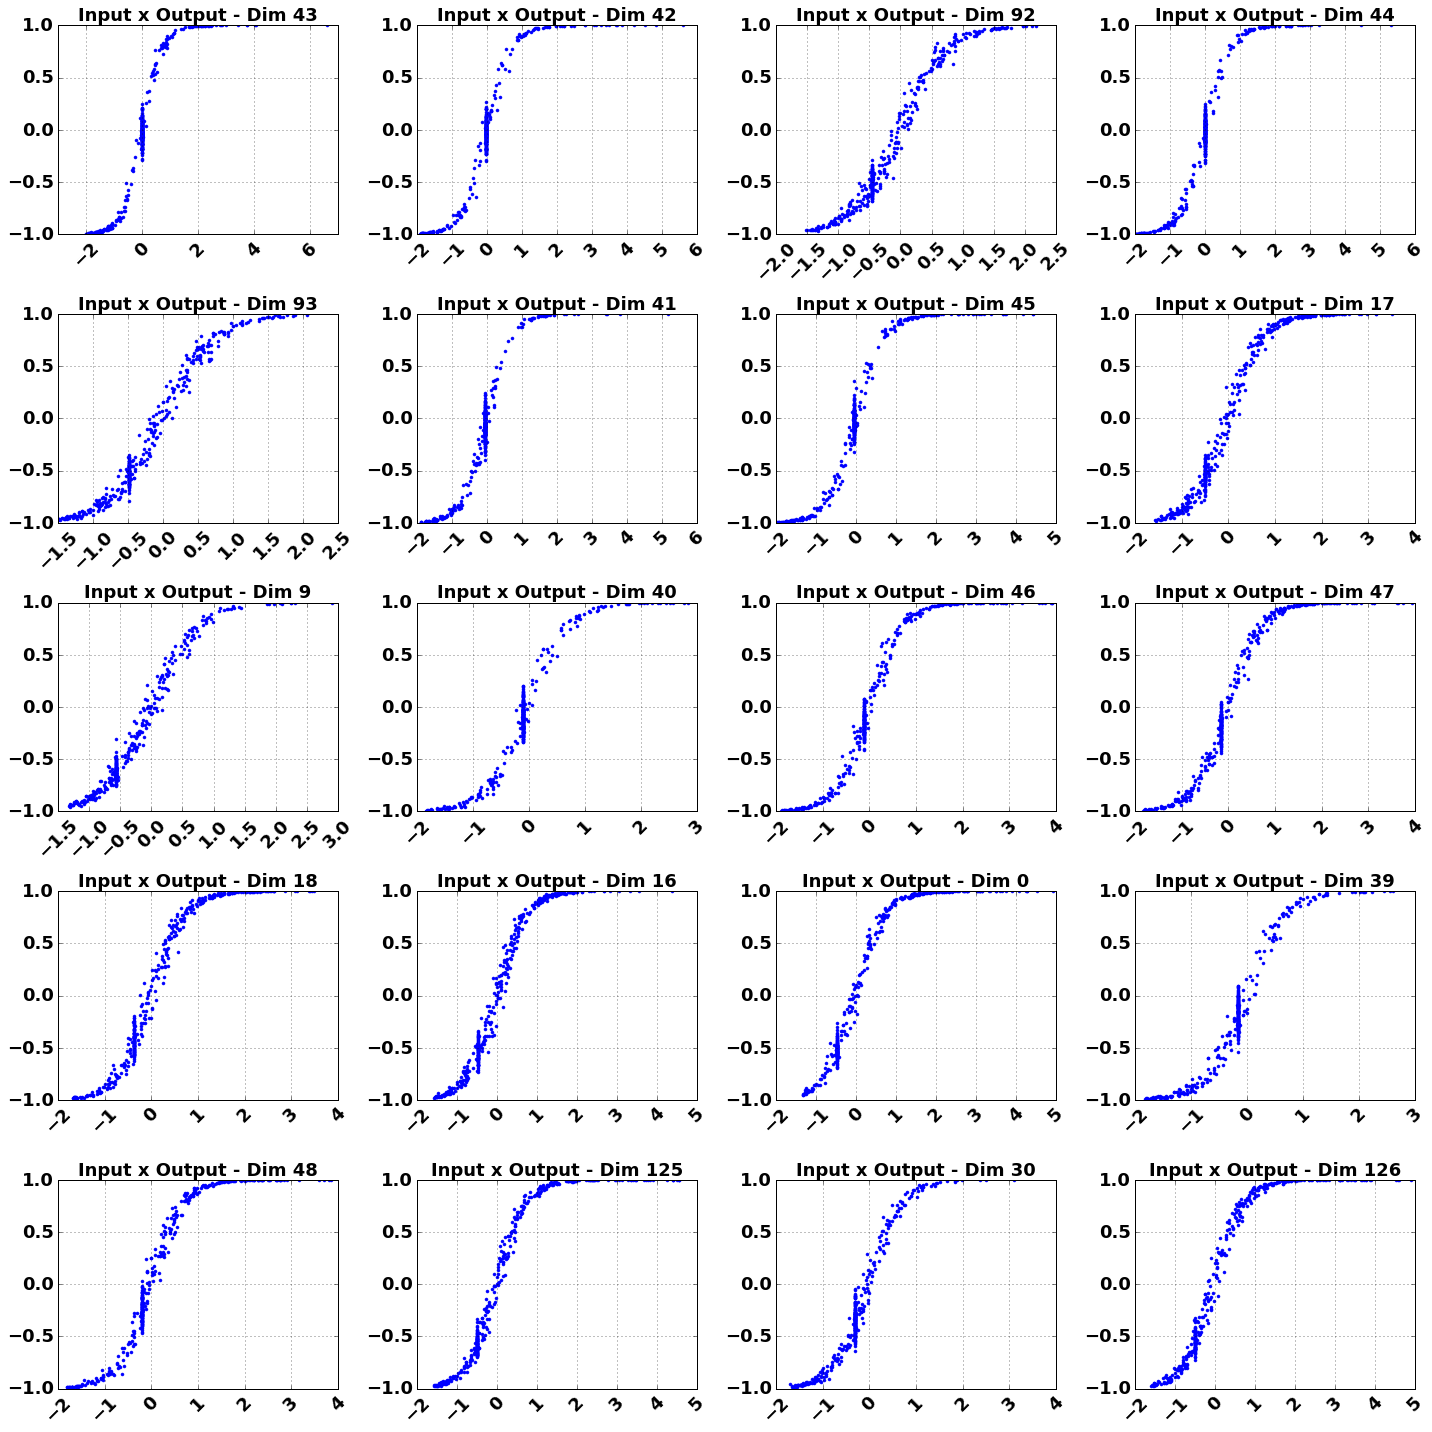

In [98]:
# Analysis of Reconstruction Input x Output

import matplotlib.pyplot as plt
%matplotlib inline  

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

current_analysis = 'reconstruction_inputxoutput'
# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3

# Number of neurons at first layer
ineuron = 450 

models = {}
outputs = {}
mean = {}
indexes = {}

diffSquared = np.zeros([len(CVO),norm_data.shape[0],norm_data.shape[1]])

for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])

    # Get the model file
    model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                               model_prefix_str,
                                               n_folds,
                                               params_str,
                                               ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)

    if not os.path.exists(file_name):
        def trainFold(ifold):
            return StackedAutoEncoderTrainFunction(data=all_data,
                                    trgt=all_data,
                                    ifold=ifold,
                                    n_folds=n_folds, 
                                    n_neurons=ineuron,
                                    trn_params=trn_params, 
                                    save_path=results_path,
                                    dev=development_flag)
        from multiprocessing import Pool
        num_processes = 10
        p = Pool(processes=num_processes)
        folds = range(len(CVO))
        results = p.map(trainFold, folds)
        p.close()
        p.join()  
        
    models[ifold]  = load_model(file_name)
    outputs[ifold] = models[ifold].predict(norm_data) 

    diffSquared[ifold] = np.power((norm_data - outputs[ifold]), 2) 

mean = np.mean(np.mean(diffSquared, axis=0), axis=0)
indexes = np.argsort(mean)[::-1]

for ifold in range(len(CVO)):
    points = all_data.shape[0]
    # Number of dimensions to analyse
    num_dim = 20
    fig, m_ax = plt.subplots(figsize=(20,20),nrows=5, ncols=4)
    for choose_index in range(num_dim):
        ax = plt.subplot(5,4,choose_index+1)
        ax.plot(norm_data[:,indexes[choose_index]][:points], outputs[ifold][:,indexes[choose_index]][:points],"b.")
        plt.tight_layout()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title('Input x Output - Dim %i'%(indexes[choose_index]),fontsize=18, fontweight='bold')
        plt.legend()
        plt.grid()    
        
#Save the figure
#plt.savefig(pict_results_path+'/'+current_analysis+'_%i'%ineuron+'_neurons'+trn_params.get_params_str()+'.pdf')
print "Topology (%s)"%trn_params.get_params_str()

## Análise de Classificação para a 1º Camada

In [33]:
%time
from sklearn import preprocessing
from sklearn import metrics

from keras.utils import np_utils
from keras.models import load_model

from Functions import TrainParameters as trnparams
def SAEClassificationTrainFunction(data=None, trgt=None, ifold=0, 
                                   n_folds=2, hidden_neurons=[1],
                                   trn_params=None, save_path='', dev=False):
    
    for i in range(len(hidden_neurons)):
        if hidden_neurons[i] == 0:
            hidden_neurons[i] = 1
    
    trgt_sparse = np_utils.to_categorical(trgt.astype(int))
    # load or create cross validation ids
    CVO = trnparams.ClassificationFolds(folder=save_path,n_folds=n_folds,trgt=trgt,dev=dev)

    n_folds = len(CVO)
    n_inits = trn_params.params['n_inits']

    params_str = trn_params.get_params_str()
    
    analysis_str = 'StackedAutoEncoder'
    prefix_str = 'RawData'
    
    # InputDimension x FirstLayerDimension x ... x OutputDimension
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    model_str = '%s/%s/Classification_(%s)_%s_%i_folds_%s'%(save_path,analysis_str,
                                                                     neurons_str,
                                                                     prefix_str, n_folds,
                                                                     params_str)

    
    if not development_flag:
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
        if os.path.exists(file_name):
            if trn_params.params['verbose']:
                print 'File %s exists'%(file_name)
            return 0
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        if os.path.exists(file_name):
            if trn_params.params['verbose']:
                print 'File %s exists'%(file_name)
            return 0

    train_id, test_id = CVO[ifold]

    #normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])

    norm_data = scaler.transform(data)
    
    best_init = 0
    best_loss = 999

    classifier = []
    trn_desc = {}

    for i_init in range(n_inits):
        print 'Fold %i of %i Folds -  Init %i of %i Inits'%(ifold+1, 
                                                            n_folds, 
                                                            i_init+1,
                                                            n_inits)

        # Get the weights of first layer
        previous_model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                   model_prefix_str,
                                                   n_folds,
                                                   params_str,
                                                   hidden_neurons[0])

        if not development_flag:
            file_name = '%s_fold_%i_model.h5'%(previous_model_str,ifold)
        else:
            file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str,ifold)
        if not os.path.exists(file_name):
            def trainFold(ifold):
                ineuron = hidden_neurons[0]
                return StackedAutoEncoderTrainFunction(data=all_data,
                                        trgt=all_data,
                                        ifold=ifold,
                                        n_folds=n_folds, 
                                        n_neurons=ineuron,
                                        trn_params=trn_params, 
                                        save_path=results_path,
                                        dev=development_flag)
            from multiprocessing import Pool
            num_processes = 10
            p = Pool(processes=num_processes)
            folds = range(len(CVO))
            results = p.map(trainFold, folds)
            p.close()
            p.join() 
        
        first_layer_model = load_model(file_name)
        first_layer = first_layer_model.layers[0]
        first_layer_weights = first_layer.get_weights()
            
        model = Sequential()
        model.add(Dense(hidden_neurons[0], input_dim=norm_data.shape[1], weights=first_layer_weights, trainable=True))
        model.add(Activation(trn_params.params['hidden_activation']))
        # Add second hidden layer
        if(len(hidden_neurons) > 1):
            previous_model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                           model_prefix_str,
                                                           n_folds,
                                                           params_str,
                                                           hidden_neurons[1])

            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(previous_model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str,ifold)
            if not os.path.exists(file_name):
                def trainFold(ifold):
                    ineuron = hidden_neurons[1]
                    return StackedAutoEncoderTrainFunction(data=all_data,
                                            trgt=all_data,
                                            ifold=ifold,
                                            n_folds=n_folds, 
                                            n_neurons=ineuron,
                                            trn_params=trn_params, 
                                            save_path=results_path,
                                            dev=development_flag)
                from multiprocessing import Pool
                num_processes = 10
                p = Pool(processes=num_processes)
                folds = range(len(CVO))
                results = p.map(trainFold, folds)
                p.close()
                p.join() 
            
            second_layer_model = load_model(file_name)
            second_layer = second_layer_model.layers[0]
            second_layer_weights = second_layer.get_weights()
            
            model.add(Dense(weights=second_layer_weights, trainable=True))
            model.add(Activation(trn_params.params['hidden_activation']))
        # Add third hidden layer    
        if(len(hidden_neurons) > 2):
            previous_model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                           model_prefix_str,
                                                           n_folds,
                                                           params_str,
                                                           hidden_neurons[2])

            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(previous_model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(previous_model_str,ifold)
            if not os.path.exists(file_name):
                def trainFold(ifold):
                    ineuron = hidden_neurons[2]
                    return StackedAutoEncoderTrainFunction(data=all_data,
                                            trgt=all_data,
                                            ifold=ifold,
                                            n_folds=n_folds, 
                                            n_neurons=ineuron,
                                            trn_params=trn_params, 
                                            save_path=results_path,
                                            dev=development_flag)
                from multiprocessing import Pool
                num_processes = 10
                p = Pool(processes=num_processes)
                folds = range(len(CVO))
                results = p.map(trainFold, folds)
                p.close()
                p.join() 
            
            third_layer_model = load_model(file_name)
            third_layer = third_layer_model.layers[0]
            third_layer_weights = third_layer.get_weights()
            
            model.add(Dense(weights=third_layer_weights, trainable=True))
            model.add(Activation(trn_params.params['hidden_activation']))
            
        # Add Output Layer
        model.add(Dense(trgt_sparse.shape[1], init="uniform")) 
        model.add(Activation('softmax'))
        
        adam = Adam(lr=trn_params.params['learning_rate'], 
                    beta_1=trn_params.params['beta_1'],
                    beta_2=trn_params.params['beta_2'],
                    epsilon=trn_params.params['epsilon'])
        
        model.compile(loss='mean_squared_error', 
                      optimizer=adam,
                      metrics=['accuracy'])
        # Train model
        earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=trn_params.params['patience'],
                                                verbose=trn_params.params['train_verbose'], 
                                                mode='auto')

        init_trn_desc = model.fit(norm_data[train_id], trgt_sparse[train_id], 
                                  nb_epoch=trn_params.params['n_epochs'], 
                                  batch_size=trn_params.params['batch_size'],
                                  callbacks=[earlyStopping], 
                                  verbose=trn_params.params['verbose'],
                                  validation_data=(norm_data[test_id],
                                                   trgt_sparse[test_id]),
                                  shuffle=True)
        if np.min(init_trn_desc.history['val_loss']) < best_loss:
            best_init = i_init
            best_loss = np.min(init_trn_desc.history['val_loss'])
            classifier = model
            trn_desc['epochs'] = init_trn_desc.epoch
            trn_desc['acc'] = init_trn_desc.history['acc']
            trn_desc['loss'] = init_trn_desc.history['loss']
            trn_desc['val_loss'] = init_trn_desc.history['val_loss']
            trn_desc['val_acc'] = init_trn_desc.history['val_acc']

    # save model
    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
        classifier.save(file_name)
        file_name = '%s_fold_%i_trn_desc.jbl'%(model_str,ifold)
        joblib.dump([trn_desc],file_name,compress=9)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        classifier.save(file_name)
        file_name = '%s_fold_%i_trn_desc_dev.jbl'%(model_str,ifold)
        print file_name
        joblib.dump([trn_desc],file_name,compress=9)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.1 µs


In [80]:
%time
# Load Parameters
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
#os.remove(trn_params_folder)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh', # For AutoEncoder
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [81]:
%time
def SAEtrainFold(ifold):
    return SAEClassificationTrainFunction(data=all_data,
                                          trgt=all_trgt,
                                          ifold=ifold,
                                          n_folds=n_folds, 
                                          hidden_neurons=[450],
                                          trn_params=trn_params, 
                                          save_path=results_path,
                                          dev=development_flag)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


In [82]:
%time
from multiprocessing import Pool
num_processes = 2
p = Pool(processes=num_processes)
start_time = time.time()
folds = range(len(CVO))

# To train on multiple cores sweeping the number of folds
results = p.map(SAEtrainFold, folds)

# To train on multiple cores sweeping the number of neurons
#results = p.map(trainNeuron, neurons)

p.close()
p.join()
end_time = time.time() - start_time
print "It took %.3f seconds to perform the training"%(end_time)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
Fold 2 of 2 Folds -  Init 1 of 1 Inits
Fold 1 of 2 Folds -  Init 1 of 1 Inits
It took 576.924 seconds to perform the training


# Análises para uma única topologia

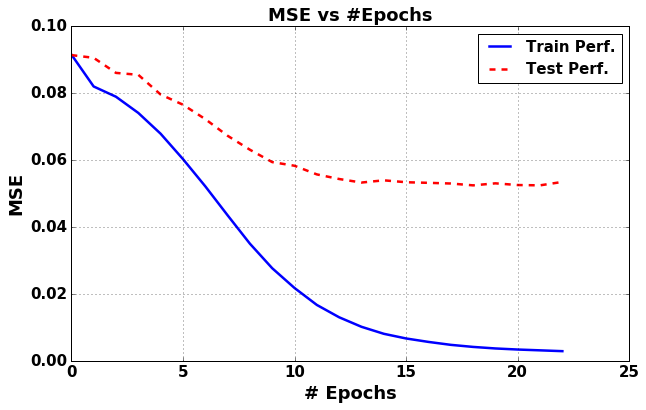

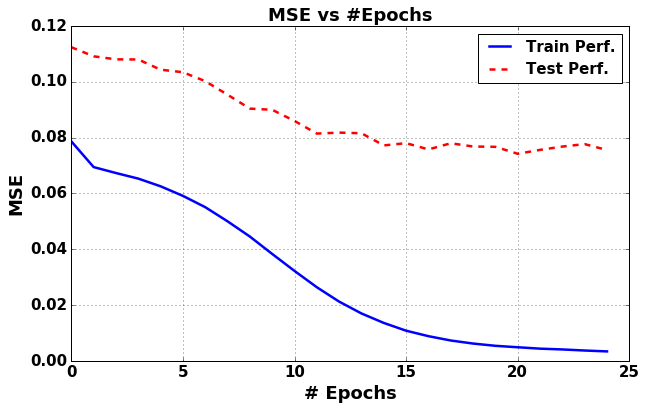

In [88]:
# Mean Squared Error x Epochs
%matplotlib inline  
import matplotlib.pyplot as plt

currentAnalysis = 'mse'
analysis_str = 'StackedAutoEncoder'
prefix_str = 'RawData'
save_path = results_path

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=300,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()

# plot train updates
for ifold in range(len(CVO)):
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rc('legend',**{'fontsize':15})
    plt.rc('font', weight='bold')
    
    fig1 = plt.figure(figsize=(10,6))
    
    hidden_neurons = [450]
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    model_str = '%s/%s/Classification_(%s)_%s_%i_folds_%s'%(save_path,analysis_str,
                                                            neurons_str,
                                                            prefix_str, n_folds,
                                                            params_str)

    if not development_flag:        
        load_file_name = '%s_fold_%i_trn_desc.jbl'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_trn_desc_dev.jbl'%(model_str,ifold)
        print load_file_name
        
    [trn_desc] = joblib.load(load_file_name)

    l1 = plt.plot(trn_desc['epochs'],
                  trn_desc['loss'],color=[0,0,1],
                  linewidth=2.5,linestyle='solid',label='Train Perf.')
    l2 = plt.plot(trn_desc['epochs'],
                  trn_desc['val_loss'],color=[1,0,0],
                  linewidth=2.5,linestyle='dashed',label='Test Perf.')
    cost = ''
    if model.loss == 'mean_squared_error':
        cost = 'MSE'

    plt.grid(True)
    plt.xlabel("# Epochs",fontsize=18,fontweight='bold')
    plt.ylabel(cost,fontsize=18,fontweight='bold')
    plt.title(cost+" vs #Epochs",fontsize=18,fontweight='bold')
    plt.legend()


Topology (Classification_(400x450x4)_RawData_2_folds_1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_tanh_output_activation)


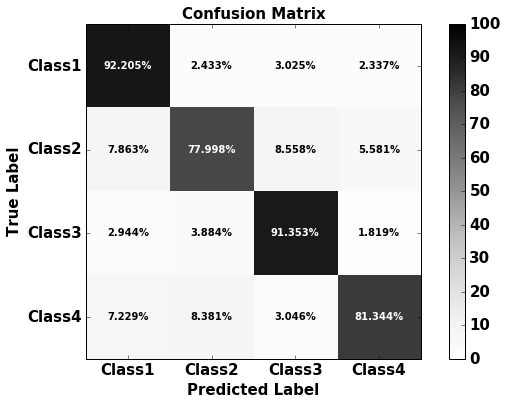

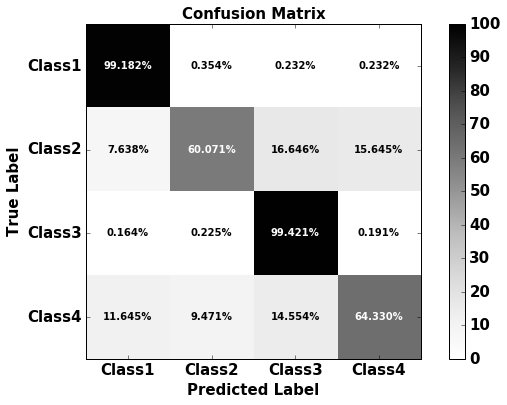

In [89]:
# Confusion Matrix

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'confusion_matrix'

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    from sklearn.metrics import confusion_matrix

    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data)

    hidden_neurons = [450]
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
    
    all_output = np.argmax(output,axis=1)
    cm = confusion_matrix(all_trgt[test_id], all_output[test_id])
    cm_normalized = 100.*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im =ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))

    width, height = cm_normalized.shape

    for x in xrange(width):
        for y in xrange(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix',fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15)
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15)
print 'Topology (%s)'%topology

In [ ]:
# Histogram

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'histogram'

# Choose Topology
hidden_neurons = [450]

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
print "Results for %i neurons (%s)"%(ineuron, params_str)
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])

    model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                   model_prefix_str,
                                                   n_folds,
                                                   params_str,
                                                   ineuron)

    if not development_flag:        
        file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
    # Check if the topology has already been trained    
    if not os.path.exists(file_name):
        NeuralTrainFunction(data=all_data,
                            trgt=all_trgt,
                            ifold=ifold,
                            n_folds=n_folds, 
                            n_neurons=ineuron,
                            trn_params=trn_params, 
                            save_path=results_path,
                            dev=development_flag)  
        
    # load weights into new model
    model = load_model(file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5, 50)

    m_colors = ['b', 'r', 'g', 'y']
    
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[all_trgt[test_id]==i_target,i_output]

            n, bins, patches = ax[i_target,i_output].hist(m_pts,bins=m_bins,
                                                          fc=m_colors[i_target],
                                                          alpha=0.8, normed=1)

            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()

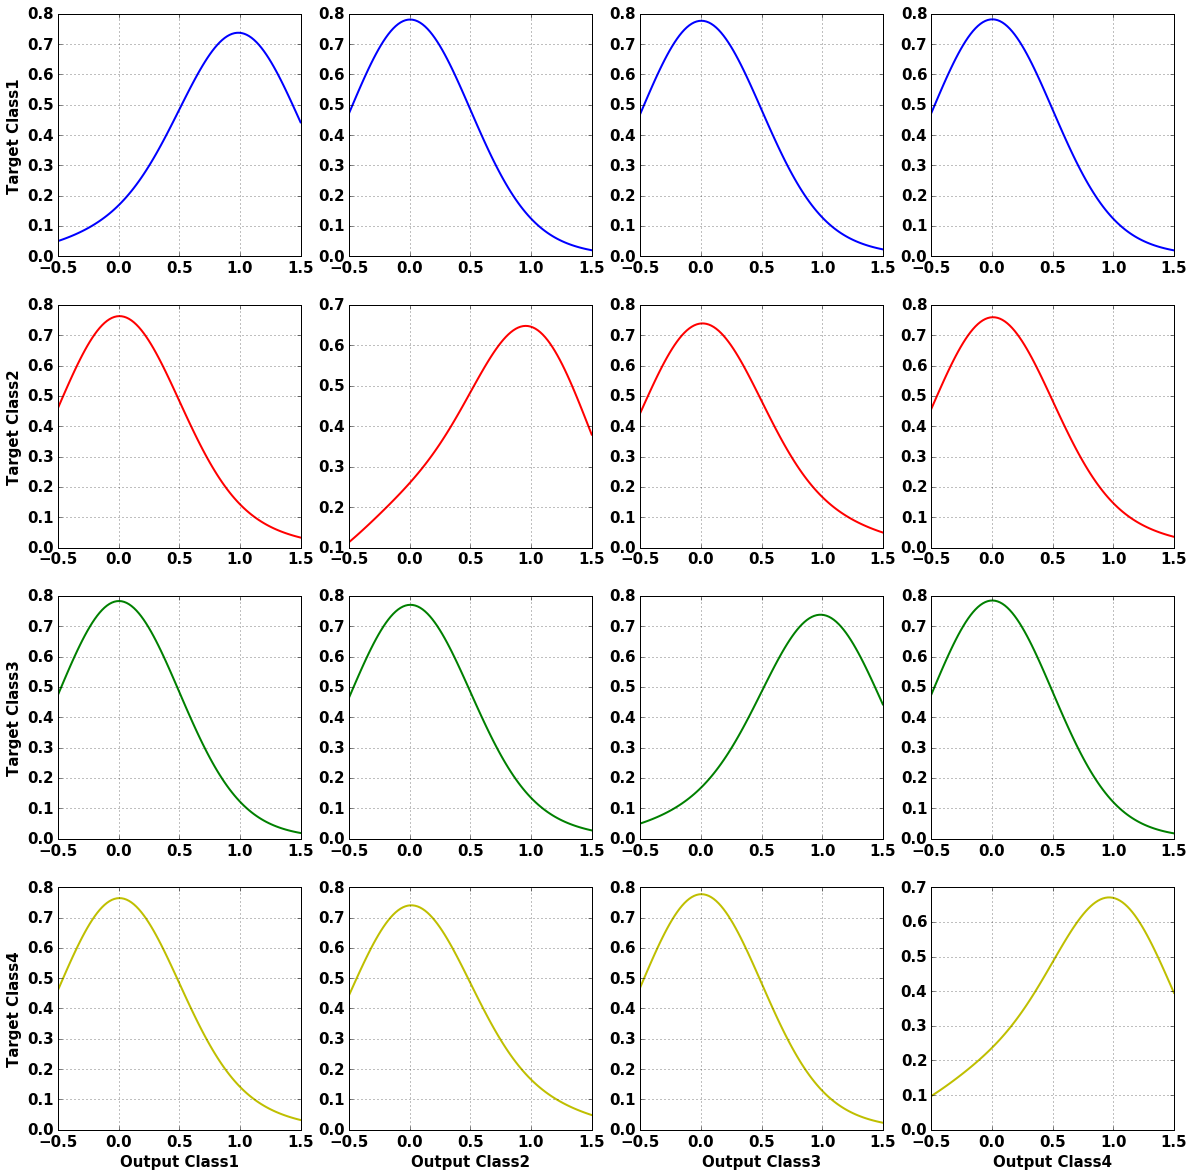

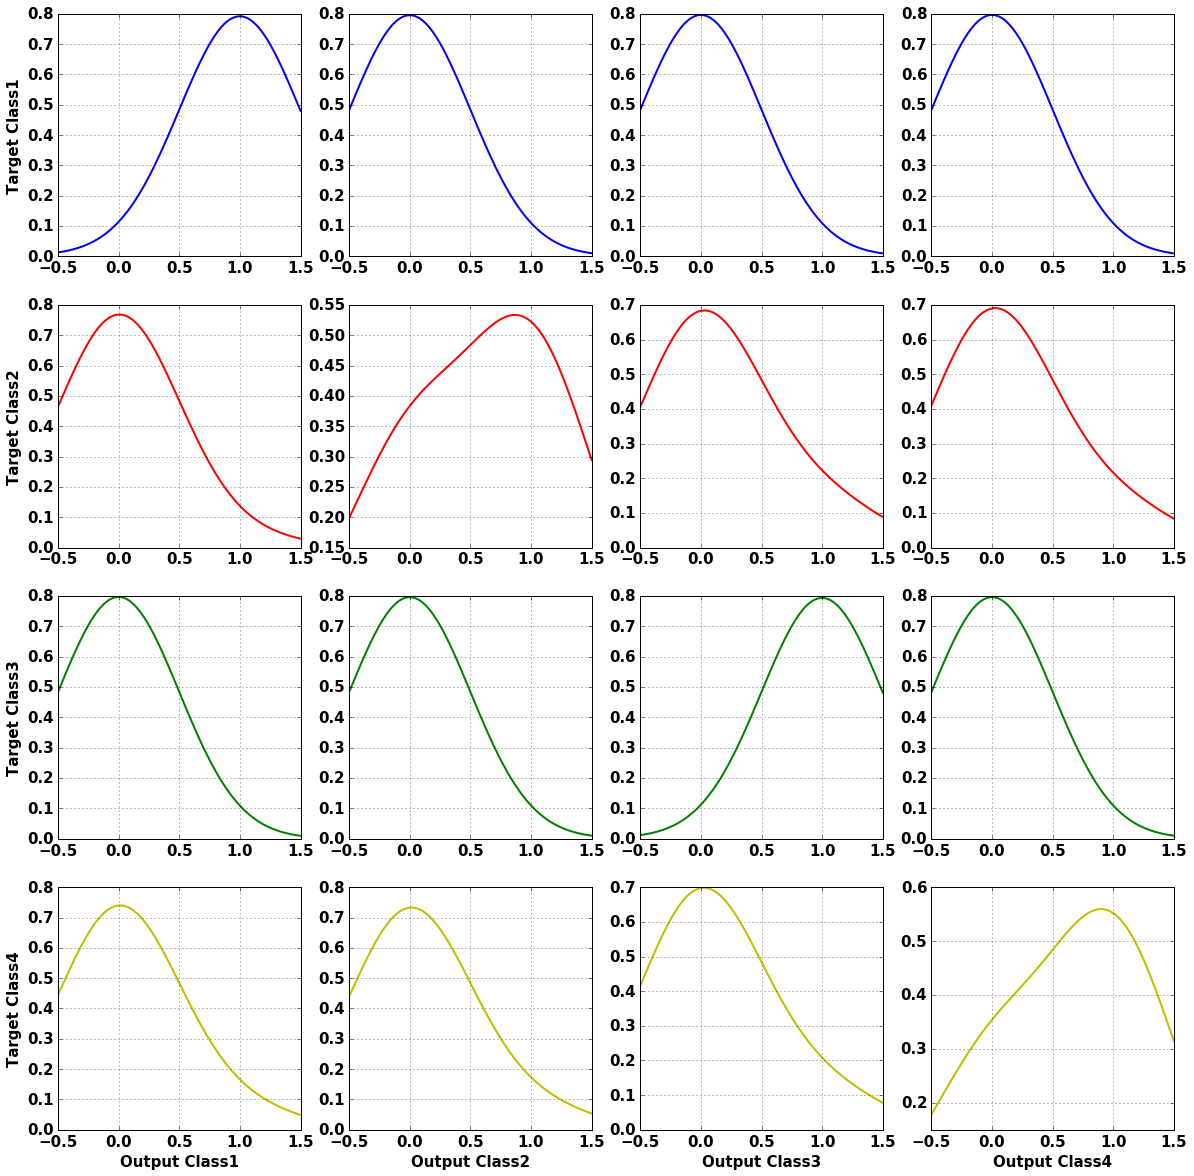

In [92]:
# Kernel Density

%matplotlib inline  
from sklearn import preprocessing

current_analysis = 'kernel_density'

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)

params_str = trn_params.get_params_str()
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    plt.rc('legend',**{'fontsize':15})

    plt.rc('font', weight='bold')

    fig, ax = plt.subplots(figsize=(20,20),nrows=4, ncols=4)
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])

    hidden_neurons = [450]
    
    neurons_str = '400'
    for ineuron in hidden_neurons:
        neurons_str = neurons_str + 'x' + str(ineuron)
    neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   
    from sklearn.neighbors import KernelDensity

    m_bins = np.linspace(-0.5, 1.5,100)

    m_colors = ['b', 'r', 'g', 'y']

    kernel = 'gaussian' # other kernels: 'gaussian', 'tophat', 
                        #'epanechnikov', 'exponential', 'linear', 'cosine'
    for i_target in range(trgt_sparse[test_id].shape[1]):
        for i_output in range(output.shape[1]):
            subplot_id = output.shape[1]*i_target+i_output
            m_pts = output[all_trgt[test_id]==i_target,i_output]

            kde = KernelDensity(kernel=kernel,algorithm='auto',
                                bandwidth=0.5).fit(m_pts[:, np.newaxis])
            log_dens_x = kde.score_samples(m_bins[:, np.newaxis])
            ax[i_target,i_output].plot(m_bins, np.exp(log_dens_x),
                                       color=m_colors[i_target],linewidth=2.0)
            if i_output == 0:
                ax[i_target,i_output].set_ylabel('Target %s'%(class_labels[i_target]),
                                                 fontweight='bold',fontsize=15)
            if i_target == 3:
                ax[i_target,i_output].set_xlabel('Output %s'%(class_labels[i_output]),
                                                 fontweight='bold',fontsize=15)
            ax[i_target,i_output].grid()

In [95]:
# Classification Report

# Choose Topology
hidden_neurons = [450]

# Parameters
trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
if not os.path.exists(trn_params_folder):
    trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='tanh',
                                                         output_activation='tanh',
                                                         n_epochs=500,
                                                         patience=50,
                                                         batch_size=256,
                                                         verbose=False)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.NeuralClassificationTrnParams()
    trn_params.load(trn_params_folder)
params_str = trn_params.get_params_str()

neurons_str = '400'
for ineuron in hidden_neurons:
    neurons_str = neurons_str + 'x' + str(ineuron)
neurons_str = neurons_str + 'x' + str(trgt_sparse.shape[1])

print "Results for (%s) neurons (%s)"%(neurons_str, params_str)
for ifold in range(len(CVO)):
    train_id, test_id = CVO[ifold]
    
    labels = class_labels.values()

    # normalize data based in train set
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

    norm_data = scaler.transform(all_data[test_id,:])
    
    # load train history
    topology = 'Classification_(%s)_%s_%i_folds_%s'%(neurons_str, prefix_str, n_folds, params_str)
    model_str = '%s/%s/%s'%(save_path,analysis_str,topology)

    if not development_flag:        
        load_file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
    else:
        load_file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
        print load_file_name
        
    # load weights into new model
    model = load_model(load_file_name)
    output = np.round(model.predict(norm_data))
   

    num_classes = len(class_labels.keys())
    
    efficiency = sklearn.metrics.recall_score(trgt_sparse[test_id], np.round(output), average=None)
    sp_index = np.sum(efficiency)/num_classes * np.power(np.prod(efficiency), 1/num_classes)
    sp_index = np.sqrt(sp_index)
    
    precision = sklearn.metrics.precision_score(trgt_sparse[test_id], np.round(output), average=None)
    f1_score = sklearn.metrics.f1_score(trgt_sparse[test_id], np.round(output), average=None)
    print '\tPrecision\tEfficiency\tF1_Score'
    for iclass in range(num_classes):
        print '%s:\t%f\t%f\t%f\n'%(class_labels[iclass], precision[iclass], efficiency[iclass],f1_score[iclass])
    print 'SP index: %f\n'%sp_index
    #print sklearn.metrics.classification_report(trgt_sparse[test_id], np.round(output), target_names=class_labels.values())

Results for (400x450x4) neurons (1_inits_mapstd_norm_500_epochs_256_batch_size_tanh_hidden_activation_tanh_output_activation)
	Precision	Efficiency	F1_Score
Class1:	0.883281	0.912170	0.897493

Class2:	0.841444	0.779981	0.809547

Class3:	0.861965	0.913532	0.887000

Class4:	0.893095	0.813437	0.851407

SP index: 0.924543

	Precision	Efficiency	F1_Score
Class1:	0.885292	0.991278	0.935292

Class2:	0.856671	0.600709	0.706212

Class3:	0.759790	0.994208	0.861334

Class4:	0.800153	0.643295	0.713201

SP index: 0.898539



In [ ]:
# analysis example - number epochs

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks

from keras.utils import np_utils
from keras.models import load_model

from Functions import TrainParameters as trnparams

# generate analysis data
save_path=results_path

analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

analysis_file_name='%s/%s/%s_epochs_sweep.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(analysis_file_name):
    
    epochs_mat = range(1,10,1)
    mse_mat = np.zeros([n_folds,len(epochs_mat)])
    
    for iepochs,epochs_value in enumerate(epochs_mat):       
        print "Number of Epochs:", epochs_value
        trn_params = trnparams.NeuralClassificationTrnParams(n_inits=1,
                                                         hidden_activation='softplus',
                                                         output_activation='softmax',
                                                         patience=50,
                                                         batch_size=512,
                                                         n_epochs=epochs_value)
    
        params_str = trn_params.get_params_str()
        print "params_str: ",params_str
        n_folds = 2
        CVO = trnparams.ClassificationFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)


        for ifold in range(len(CVO)):
            train_id, test_id = CVO[ifold]

            # normalize data based in train set
            if trn_params.params['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
            elif trn_params.params['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
            elif trn_params.params['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])

            norm_data = scaler.transform(all_data)
            
            neurons =10
            NeuralTrainFunction(data=all_data, trgt=all_trgt, ifold=ifold, n_folds=n_folds, 
                                n_neurons=neurons, trn_params=trn_params, 
                                save_path=results_path,dev=True)

            # turn targets in sparse mode
            trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))


            model_str = '%s/%s/%s_%i_folds_%s_%i_neurons'%(save_path,analysis_str,
                                                           model_prefix_str,
                                                           n_folds,
                                                           params_str,
                                                           neurons)

            model = Sequential()
            model.add(Dense(neurons, input_dim=data.shape[1], init="uniform"))
            model.add(Activation(trn_params.params['hidden_activation']))
            model.add(Dense(trgt_sparse.shape[1], init="uniform")) 
            model.add(Activation(trn_params.params['output_activation']))

            if not development_flag:        
                file_name = '%s_fold_%i_model.h5'%(model_str,ifold)
            else:
                file_name = '%s_fold_%i_model_dev.h5'%(model_str,ifold)
                
            print 'Model name: %s'%(file_name)
            model = load_model(file_name)
            output = model.predict(norm_data)
            mse = np.mean(np.sum((trgt_sparse-output)**2))
            mse_mat[ifold,iepochs] = mse
    joblib.dump([mse_mat,epochs_mat],analysis_file_name,compress=9)
else:
    [mse_mat,epochs_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10),nrows=1, ncols=1)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

ax.errorbar(epochs_mat,np.mean(mse_mat,axis=0),
            np.std(mse_mat,axis=0),fmt='o-',
            color='k',alpha=0.7,linewidth=2.5)
ax.set_title('MSE per Number of Epochs',fontsize=18,weight='bold')
ax.set_xlabel('Epochs',fontsize=18,weight='bold')
ax.set_ylabel('MSE Value',fontsize=18,weight='bold')